In [2]:
import CanDI as can
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


### Cancer Object Instantiation
We're interested in cross referencing some data in breast and ovarian cancer so instantiate cancer objects as follows.
To double check the object instantiation I check the length of the depmap_id vectors. This lets me know we're able to index other datasets correctly

In [3]:
ov = can.Cancer("Ovarian Cancer")
br = can.Cancer("Breast Cancer")

#Number of Ovarian Cell lines
print(len(ov.depmap_ids))
#Number of Breast Cell Lines
print(len(br.depmap_ids))

74
83


### Subsetting by mutation status

Explicitly load mutations into memory.This only needs to be done once
You will be done prompted to load a given dataset if using operations that act
on that dataset and it is not in memory.

In [4]:
can.data.load("mutations")

,gene,Entrez_Gene_Id,NCBI_Build,Chromosome,Start_position,End_position,Strand,Variant_Classification,Variant_Type,Reference_Allele,...,isCOSMIChotspot,COSMIChsCnt,ExAC_AF,Variant_annotation,CGA_WES_AC,HC_AC,RD_AC,RNAseq_AC,SangerWES_AC,WGS_AC
0,VPS13D,55187,37,1,12359347,12359347,+,Nonsense_Mutation,SNP,C,...,False,0.0,NaN,damaging,34:213,NaN,NaN,NaN,34:221,NaN
1,AADACL4,343066,37,1,12726308,12726322,+,In_Frame_Del,DEL,CTGGCGTGACGCCAT,...,False,3.0,NaN,other non-conserving,57:141,NaN,NaN,NaN,9:0,28:32
2,IFNLR1,163702,37,1,24484172,24484172,+,Silent,SNP,G,...,False,0.0,NaN,silent,118:0,NaN,NaN,10:0,118:0,18:0
3,TMEM57,55219,37,1,25785018,25785019,+,Frame_Shift_Ins,INS,-,...,False,0.0,NaN,damaging,NaN,NaN,NaN,6:28,NaN,NaN
4,ZSCAN20,7579,37,1,33954141,33954141,+,Missense_Mutation,SNP,T,...,False,0.0,NaN,other non-conserving,28:62,NaN,NaN,NaN,27:61,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1269994,EHBP1L1,254102,37,11,65350600,65350600,+,Frame_Shift_Del,DEL,G,...,False,0.0,NaN,NaN,61:69,NaN,NaN,NaN,NaN,NaN
1269995,SACS,26278,37,13,23904582,23904582,+,Frame_Shift_Del,DEL,T,...,False,0.0,NaN,NaN,88:1,NaN,NaN,NaN,NaN,NaN
1269996,CBFB,865,37,16,67070637,67070638,+,Frame_Shift_Ins,INS,-,...,False,0.0,NaN,NaN,31:0,NaN,NaN,NaN,NaN,NaN
1269997,TAF15,8148,37,17,34171711,34171734,+,In_Frame_Del,DEL,GGCTATGGAGGAGACCGAGGAGGT,...,False,0.0,NaN,NaN,24:28,NaN,NaN,NaN,NaN,NaN


I want to look at BRCA1 mutations in these types of cancers. I start by using the mutated function to identify ovarian and breast cancer cell lines with BRCA1 mutations. A cancer object's mutated method's default behavior is to output a list of depmap ids corresponding to celllines containing any mutation within the given genes. I then instantiate CellLineCluster objects of exclusively mutated or wild type cell lines for both breast and ovarian cancer. This makes comparing these cell lines easier.
    

In [49]:
ov_mt_list = ov.mutated(["BRCA1"]) #List of depmap_ids
br_mt_list = br.mutated(["BRCA1"]) #list of depmap_ids

ov_mt = can.CellLineCluster(ov_mt_list) #CellLineCluster obj
br_mt = can.CellLineCluster(br_mt_list)


print("Depmap_ids attribute should be the same as the list used to instantiate the CellLineCluster object\n")
print(ov_mt.depmap_ids == ov_mt_list)

#CellLineCluster ojbect must be instantiated with a mutable sequence
#I use set operations to get wild type cell line ids and convert to a list
ov_wt_list = list(set(ov.depmap_ids) - set(ov_mt_list))
br_wt_list = list(set(br.depmap_ids) - set(br_mt_list))

ov_wt = can.CellLineCluster(ov_wt_list)
br_wt = can.CellLineCluster(br_wt_list)
print(ov_wt.depmap_ids == ov_wt_list)

Depmap_ids attribute should be the same as the list used to instantiate the CellLineCluster object

True
True


### Cross Referencing Mutation and Gene Knockout Data
I'm interested in how the mutation status of BRCA1 effects a cancer's dependency on the fanconi anemia genes.
To visualize this relationship I am going to make a heatmap of fanconi anemia genes sorting the cell lines by their BRCA1 mutation status. The following cell defines a function that plots a heatmap of the gene effect of the fanconi anemia genes separating them by the BRCA1 mutation status of a given cell line. 


In [6]:
def gene_effect_heatmap(obj1, obj2, genes, name = None):
    
    #Make Figure appropriate size, dpi, and font
    plt.rcParams.update({"figure.figsize": (16, 6),
                        "savefig.dpi": 300,
                        "font.family": "sans-serif",
                        "font.sans-serif": ["Arial"],
                        "font.size": 12
                        })
    
    #One figure with one subplot
    fig, ax = plt.subplots(1,1)
    
    #Construcat matrix to make heatmap and cell line labels
    data = pd.concat([obj1.effect_of(genes), obj2.effect_of(genes)], axis=1)
    names = can.data.cell_lines.loc[data.columns, "cell_line_name"]
        
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(names)))
    ax.set_yticks(np.arange(len(genes)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(names)
    ax.set_yticklabels(genes)
    
    #make heatmap
    im = ax.imshow(data, cmap="RdBu")
    
    #Make colorbar scale to axis
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = ax.figure.colorbar(im, ax = ax, cax = cax)
    cbar.ax.set_ylabel("Gene Effect", rotation=-90, va="bottom")
    
    #Draw Dividing line btween mutant and
    ax.axvline(x=obj1.gene_effect.shape[1] - 0.5, c = "black", linewidth = 3)
    plt.setp(ax.get_xticklabels(), rotation=-90, ha="left", va="center",
         rotation_mode="anchor")
    plt.tight_layout()
    plt.show()
    
    if name:
        fig.savefig(name, dpi=300)


### Fanconi Anemia Genes Knockout Effect in Ovarian Cancer
BRCA1 Mutant Left of Vertical Line

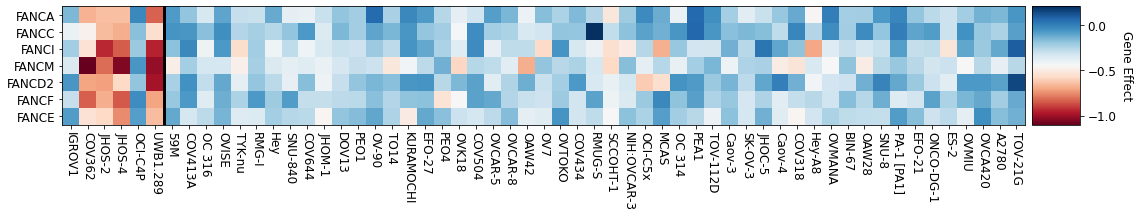

In [52]:
genes = ["FANC" + i for i in ["A", "C", "I", "M", "D2", "F", "E"]]
gene_effect_heatmap(ov_mt, ov_wt, genes, name = "figures/ov_brca1_heatmap.pdf")

### Fanconi Anemia Genes Knockout Effect in Breast Cancer
BRCA1 Mutant Left of Vertical Line

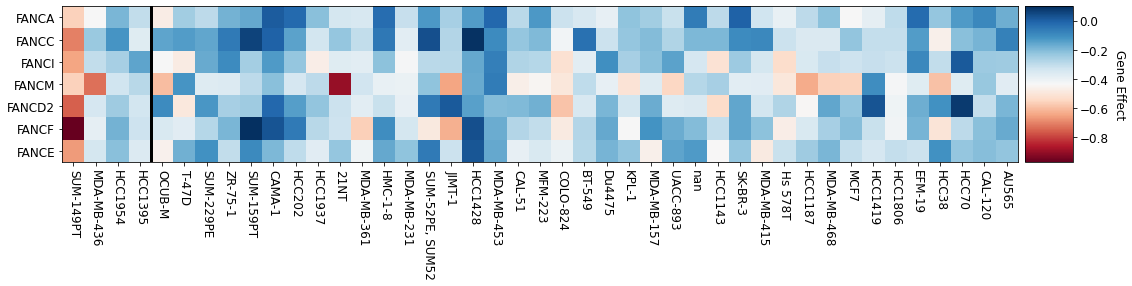

In [53]:
gene_effect_heatmap(br_mt, br_wt, genes, name = "figures/br_brca1-2_heatmap.pdf")